In [3]:
from pymongo import MongoClient

In [4]:
mGClient = MongoClient(f'mongodb://10.250.4.35:27017')
collection = mGClient['experiments']['Exp_prova_christian_good_btsData']


In [5]:
# query = { "experimentId": "664765192067e22ac8ea9e64" }
data = collection.find()

In [6]:
datali = list(data)
print(len(datali))

120000


In [22]:
from collections import defaultdict
from scipy import signal
import numpy as np

Sampling_frequency = 1000
band_lo = 20
band_hi = 450
Niquist_frequency = Sampling_frequency/2
nor_band_lo = band_lo/Niquist_frequency
nor_band_hi = band_hi/Niquist_frequency
sos_band = signal.iirfilter(4, [ nor_band_lo, nor_band_hi],btype='band', ftype='butter', output = "sos")
del_freq = 50
nor_del_freq = del_freq/Niquist_frequency
Quality = 30
b_notch, a_notch = signal.iirnotch(nor_del_freq, Quality, Sampling_frequency)

def filtering2(data: defaultdict) -> dict:
    """
    Returns the data filtered with bandpass and notch filters
        Inputs:
            data: database with the data of the sensors
        Outputs:
            filtered_data: database with the data of the sensors filtered
    """
    filtered_data = dict()
    for key, value in data.items():
        signal_array = np.array(value)
        # signal_array = signal_array[signal_array[:,1] == 1][-2000:,:]

        signal_array_band = signal.sosfiltfilt(sos_band , signal_array[:,2])
        filtered = signal.lfilter(b_notch, a_notch, signal_array_band)
        signal_array[:,2] = filtered
        filtered_data[key] = signal_array
    print(data.keys())
    return filtered_data

In [23]:
import analysis_functions.btsAnalysis as baf
from collections import defaultdict

dataMongo = defaultdict(list)

for x in datali:
        try:
            samples : list = x["samples"]
            for sample in samples:
                
                dataMongo[str(sample["sensorLabel"])].append((x["index"], sample["status"], sample["value"]))
        except:
            print(x)

filt_data = filtering2(dataMongo)

dict_keys(['1', '3', '5', '7'])


In [24]:
import scipy.integrate as integrate



In [25]:
integrals = []
sens_1 = filt_data["1"]
print(len(sens_1))
for i in range(0,len(sens_1),200):
    data_batch = sens_1[i:i+200]
    data_filt = [abs(k[2]) for k in data_batch if k[1]==1]
    integrals.append(integrate.simpson(data_filt, dx=0.001))

120000


In [26]:
import matplotlib.pyplot as plt

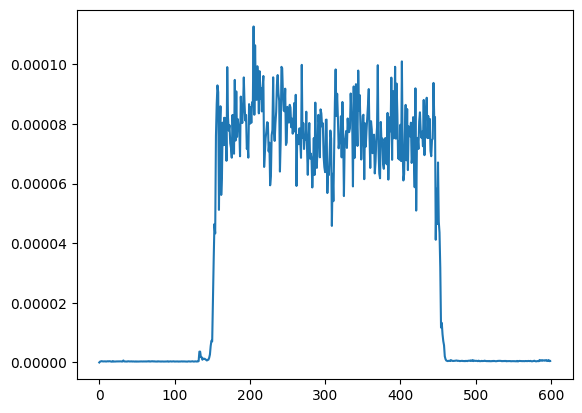

In [27]:
plt.plot(integrals)

In [53]:
prev_int = 0
new_int = 0

integrals_waighted = []
for i in integrals:
    prev_int = new_int
    new_int = prev_int*0.992 +i
    integrals_waighted.append(new_int)

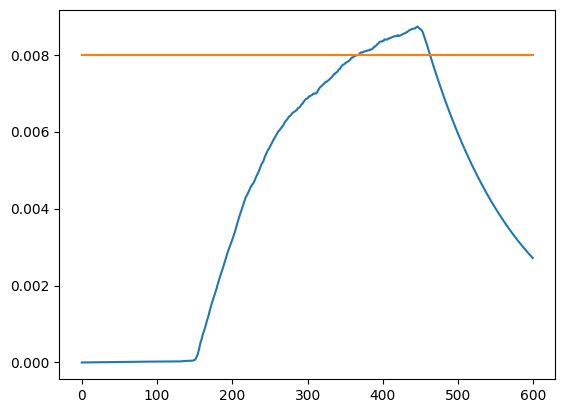

In [55]:
limit = [0.008 for i in range(len(integrals_waighted))]
plt.plot(integrals_waighted)
plt.plot(limit)
